# ACLScheduleTest Demo

* 需要提前安装好ACLScheduleTest库。在schedule_test目录中，根据其目录下`README.md`很轻松得到安装。
* 本文档主要介绍一下使用流程，给出演示demo。
* 为方便测试，WizardQuant提供了服务器资源（已配置好对应环境直接开发）。可以联系`huzeyu@wizardquant.com`获取到服务器账户密码。


## 导入包

In [20]:
from ACLScheduleTest.Simulate import Simulator
from ACLScheduleTest.Analysis import Analyst
from ACLScheduleTest.data import RandomDsk

## 调度流程

1. 开始调度
    1. 刷新一下状态，每个工作的worker计时器`+1`；把完成任务的节点释放掉。并把结果写进`cache`中
    2. 调用`schedule_out_func`，释放资源
    3. 检查所有worker给没有工作的worker都看看能不能安排好任务（调用`schedule_in_func`）。
2. 退出调度的条件
    1. 所有`factor_node_dict`都被计算完，此时调度算法正确完成所有任务（`Task Finished`）。
    2. 发现所有worker都休息了，此时调度算法失败（发生阻塞，`Poor Algo`）。
    3. 超出理论最长计算时间，该时间固定为`节点个数 * 完成所有任务的总时间`，此时调度算法失败（`Time limit exceeded`）。
    4. `schedule_in` 尝试计算一个前置资源未准备好的节点，此时调度算法失败（`Look Future`）。
    5. 使用的内存超出内存限制`mem_bound`，调度算法失败（`Out of Memory`）。
 
 详细文档见，notebook最后一个block

## 自定义函数

* 包含有`schedule_in_func`, `schedule_out_func`

### schedule_in_demo

In [21]:
def schedule_in_demo(workers, cache, av_mem, factor_node_dict, calculated_node_dict, dsk, global_dict):
    # need to calculater
    factor_node = set([k for k in factor_node_dict if factor_node_dict[k] is None])

    if len(factor_node) == 0:
        return None

    workers_nodes = set([workers[k][0] for k in workers if workers[k] is not None])

    def topoOrder():
        topoQueue = []
        q = list(factor_node - set(cache.keys()) - workers_nodes)

        nodeList = set(dsk.keys()) - set(factor_node)
        while len(q):
            node, q = q[0], q[1:]

            topoQueue.append(node)

            append_nodes = [arg for arg in dsk[node][1:] if
                            (arg in nodeList) and (arg not in cache.keys()) and (arg not in workers_nodes)]
            nodeList = nodeList - set(append_nodes)
            q = q + append_nodes
        return topoQueue

    topo_node = topoOrder()

    nodeList = dsk.keys()

    def available_node():
        for node in topo_node:
            if dsk[node][0].mem > av_mem:
                continue
            args = dsk[node][1:]
            isAvailable = True
            for arg in args:
                if (arg in nodeList) and (arg not in cache):
                    isAvailable = False
                    break
            if isAvailable:
                return node
        return None

    return available_node()

### schedule_out_func

In [22]:
def schedule_out_demo(workers, cache, av_mem, factor_node_dict, calculated_node_dict, dsk, global_dict):
    # need to calculater
    factor_node = set([k for k in factor_node_dict if factor_node_dict[k] is None])

    if len(factor_node) == 0:
        return []

    workers_nodes = set([workers[k][0] for k in workers if workers[k] is not None])

    def topoOrder():
        topoQueue = []
        q = list(factor_node - set(cache.keys()) - workers_nodes)

        nodeList = set(dsk.keys()) - set(factor_node)
        while len(q):
            node, q = q[0], q[1:]

            topoQueue.append(node)

            append_nodes = [arg for arg in dsk[node][1:] if
                            (arg in nodeList) and (arg not in cache.keys()) and (arg not in workers_nodes)]
            nodeList = nodeList - set(append_nodes)
            q = q + append_nodes
        return topoQueue

    topo_node = topoOrder()

    def trash_cache():
        trash_node = []

        for node in cache:
            isTrash = True
            for tp_node in topo_node + list(workers_nodes):
                if node in dsk[tp_node][1:]:
                    isTrash = False
                    break
            if isTrash:
                trash_node.append(node)
        return trash_node

    return trash_cache()

## 创建随机图生成器

* **参数不要变!!!**
* 该组参数保证生成图中，每个节点的计算时间都是单位长度，存储该节点产出的内容所占空间大小都是单位大小。
* 该组参数即为本次题目中采用的随机生成器。

In [23]:
rd = RandomDsk(
    mute=True, node_num=100,
    st_node_num=10,
    min_time=1, time_lv=0, time_rv=0, min_time_step=0,
    avg_mem_peek=1, mem_pv=0, mem_sv=1
)

In [24]:
dsk = rd.build()

In [25]:
for node in dsk:
    print(dsk[node][0].time == 1, dsk[node][0].mem == 1)

True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True


## 创建Simulator

In [26]:
sim = Simulator()

* 成功了，则会有一个info，以及有两个图(第一个是内存在每个时刻的使用情况， 第二个是每个时刻进程使用情况)
* 否则返回的是失败时候系统状态

=========summary info============
Time: 15
Mem Peek: 47.0
MemUsingRate: 0.528
WorkerUsingRate: 0.6666666666666667


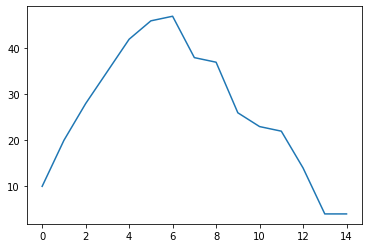

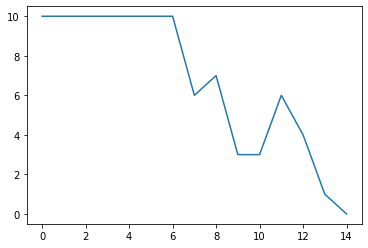

In [27]:
sim.simulate(schedule_in_demo, schedule_out_demo, mem_bound=50, worker_bound=10, rd=rd)

In [28]:
result = sim.simulate(schedule_in_demo, schedule_out_demo, mem_bound=50, worker_bound=10, rd=rd, compare_mode=True)
result

{'TaskSuccess': True,
 'schedule_mem_series': 0     10.0
 1     16.0
 2     24.0
 3     32.0
 4     40.0
 5     41.0
 6     41.0
 7     41.0
 8     40.0
 9     28.0
 10    20.0
 11    14.0
 12     6.0
 13     6.0
 dtype: float64,
 'schedule_worker_series': 0     10
 1      6
 2      9
 3      9
 4     10
 5     10
 6     10
 7      9
 8      9
 9      6
 10     5
 11     5
 12     2
 13     0
 dtype: int64,
 'bm_mem': 100.0,
 'bm_time': 100}

In [29]:
analyst = Analyst()

In [30]:
sucess_rate, speed_up = analyst.run(result=[[result]])

* 成功率

In [31]:
sucess_rate

[1.0]

* 加速比(这里的workers数量是10，而加速比越接近10则效果越好)

In [13]:
speed_up

,0
0,7.692308


### 多次测试

因为上面是只进行一次实验，结论不是那么可靠。

* 因此多进行几次实验
* N=测试次数
* num_cpus=用于加速回测计算的多进程数量。

In [14]:
sucess_rate, speed_up = sim.compare([(schedule_in_demo, schedule_out_demo),], rd=rd, mem_bound=50,
                                    analyst=analyst, num_cpus=3, N=100)

In [15]:
sucess_rate, speed_up

([1.0],
            0
 0   7.142857
 1   7.692308
 2   7.692308
 3   7.692308
 4   7.142857
 ..       ...
 95  7.692308
 96  7.692308
 97  6.666667
 98  7.142857
 99  7.692308
 
 [100 rows x 1 columns])

In [19]:
import numpy as np
np.array(speed_up).mean()

7.333594591682827

* 也可以不传analyst，这样得到就是results的结果（不过是二维数组）

In [16]:
results = sim.compare([(schedule_in_demo, schedule_out_demo),], rd=rd, mem_bound=50,
                      num_cpus=3, N=100)

In [17]:
results

[[{'TaskSuccess': True,
   'schedule_mem_series': 0     10.0
   1     20.0
   2     26.0
   3     31.0
   4     37.0
   5     40.0
   6     39.0
   7     34.0
   8     29.0
   9     30.0
   10    19.0
   11     6.0
   12     3.0
   13     3.0
   dtype: float64,
   'schedule_worker_series': 0     10
   1     10
   2     10
   3     10
   4     10
   5     10
   6      9
   7      5
   8      7
   9      9
   10     6
   11     3
   12     1
   13     0
   dtype: int64,
   'bm_mem': 100.0,
   'bm_time': 100}],
 [{'TaskSuccess': True,
   'schedule_mem_series': 0     10.0
   1     20.0
   2     28.0
   3     33.0
   4     39.0
   5     46.0
   6     43.0
   7     43.0
   8     30.0
   9     26.0
   10     7.0
   11     7.0
   dtype: float64,
   'schedule_worker_series': 0     10
   1     10
   2     10
   3     10
   4     10
   5     10
   6     10
   7     10
   8      9
   9      9
   10     2
   11     0
   dtype: int64,
   'bm_mem': 100.0,
   'bm_time': 100}],
 [{'TaskSuccess': True,


## 评判标准

1. 在mem_bound的限制下调度算法完成率。（越高越好）
2. 算法加速比如何（越大越好）
3. 对mem的占用情况如何（越小越好），避免浪费

* 注意：mem_bound并不是上面写的50，是可能会更低的，而在mem_bound更低的情况下，算法是否还能保住成功率也是第一条指标的考核因素。

## Hints

一个节点，也被叫作一个任务

1. 一个任务的计算过程中，它所需要的输入数据必须要一直存在cache中。否则算任务失败。
2. demo给出的调度算法。有种情况，资源会出现卡住的情况，即，cache中的资源都在未来会用到（但占满了空间），此时却无法再调度起一个新的任务。有两种思路，因为图是已知的，因此可以提前预判到这种情况发生，从而调整对应节点的调度顺序；对于内存的节点移除内存，并在未来重新计算。
3. 调度算法，相关信息除了可以找论文，也可以查看dask，ray等分布式调度框架源码or文档。
4. 通过启发式的思路可以很容易想到对应的求解，但也会有各种问题。其实也可以尝试最大割，智能算法（PSO，模拟退火，蚁群等），强化学习进行求解。
